[View in Colaboratory](https://colab.research.google.com/github/webserg/pythonML/blob/master/colab/plankton.ipynb)

https://www.kaggle.com/c/datasciencebowl/data
http://benanne.github.io/2015/03/17/plankton.html


In [11]:
!pip install kaggle

  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/d6/3c/92/375decc0cf0a65b281db3cca9b8e21dc27b8ebc4d1ce29afca
Successfully built kaggle


In [12]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [13]:
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
imagenet-object-detection-challenge             2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-detection-from-video-challenge  2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-localization-challenge          2029-12-31 07:00:00  Research         Knowledge          8           False  
titanic                                         2020-04-07 00:00:00  Getting Started  Knowledge      11326            True  
house-prices-advanced-regression-techniques     2020-03-01 23:59:00  Getting Started  Knowledge       5397           False  
digit-recognizer                                2020-01-07 00:00:00  Getting Started  Knowledge       2506           False  


In [8]:
!pwd

/content


In [0]:
!mkdir datasciencebowl

In [15]:
!ls -l

total 8
drwxr-xr-x 1 root root 4096 May 18 20:25 datalab
drwxr-xr-x 2 root root 4096 May 18 20:25 datasciencebowl


In [16]:
!kaggle competitions download -c datasciencebowl -p ./plankton

sampleSubmission.csv.zip: Downloaded 886KB of 886KB to ./plankton
train.zip: Downloaded 76MB of 76MB to ./plankton
test.zip: Downloaded 347MB of 347MB to ./plankton
plankton_identification.pdf: Downloaded 2MB of 2MB to ./plankton


In [30]:
%cd /content/plankton/validation/

/content/plankton/validation


In [28]:
%ls -l

total 3684
drwxr-xr-x 2 root root 3768320 May 18 20:28 test/


In [19]:
import zipfile
import os
data_dir = "/content/plankton"
path_to_data = "/content/plankton/train.zip"
path_to_data

'/content/plankton/train.zip'

In [0]:
if os.path.exists(data_dir) == False:
    os.makedirs(data_dir)

In [0]:
zip_ref = zipfile.ZipFile(path_to_data, 'r')
zip_ref.extractall(data_dir)
zip_ref.close()

In [21]:
path_to_test = "/content/plankton/test.zip"
path_to_test

'/content/plankton/test.zip'

In [0]:
 os.makedirs(data_dir + "/test")

In [0]:
zip_ref = zipfile.ZipFile(path_to_test, 'r')
zip_ref.extractall(data_dir + "/test")
zip_ref.close()

In [0]:
validation_dir = os.path.join(data_dir, 'validation')
if os.path.exists(validation_dir) == False:
    os.mkdir(validation_dir)

In [0]:
import shutil
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [0]:
validation_dir = os.path.join(data_dir, 'validation')

dir_info = [x for x in os.walk(train_dir)]
for dir in dir_info[1:]:
    print(len(dir[2]))
    validation_number = int(round(len(dir[2])/10))
    print(validation_number)
    print(dir[2])
    print(dir[2][:validation_number])
    dir_name = os.path.split(dir[0])[1]
    print(dir_name)
    validation_dir_current = os.path.join(validation_dir, dir_name)
    if os.path.exists(validation_dir_current) == False:
        os.mkdir(validation_dir_current)
    for fname in dir[2][:validation_number]:
        src = os.path.join(train_dir, dir_name, fname)
        dst = os.path.join(validation_dir_current, fname)
        print(src)
        print(dst)
        shutil.move(src, dst)


In [0]:
if os.path.exists(validation_dir) == False:
    print("false")

In [34]:
print('total training categories:', len(os.listdir(train_dir)))
cpt = sum([len(files) for r, d, files in os.walk(train_dir)])
print('all train images: ',cpt )

total training categories: 121
all train images:  27304


In [35]:
print('total validation categories:', len(os.listdir(validation_dir)))
cpt = sum([len(files) for r, d, files in os.walk(validation_dir)])
print('all train images: ',cpt )

total validation categories: 121
all train images:  3032


In [36]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=20,
class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=20,
class_mode='categorical')

Using TensorFlow backend.


Found 27304 images belonging to 121 classes.
Found 3032 images belonging to 121 classes.


In [37]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(121, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [0]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['acc'])

In [39]:
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
validation_steps=50)
model.save('/content/plankton/plankton_1.h5')

Epoch 1/30
100/100 [==============================] - 8s 81ms/step - loss: 4.2815 - acc: 0.0845 - val_loss: 4.1399 - val_acc: 0.1210
Epoch 2/30
100/100 [==============================] - 6s 58ms/step - loss: 4.0871 - acc: 0.1055 - val_loss: 3.9092 - val_acc: 0.1360
Epoch 3/30
100/100 [==============================] - 6s 59ms/step - loss: 3.7274 - acc: 0.1650 - val_loss: 3.4829 - val_acc: 0.2210
Epoch 4/30
100/100 [==============================] - 6s 59ms/step - loss: 3.4398 - acc: 0.2260 - val_loss: 3.2470 - val_acc: 0.2470
Epoch 5/30
 16/100 [===>..........................] - ETA: 4s - loss: 3.4657 - acc: 0.2094

100/100 [==============================] - 6s 60ms/step - loss: 3.2605 - acc: 0.2475 - val_loss: 3.0873 - val_acc: 0.2690
Epoch 6/30
100/100 [==============================] - 6s 59ms/step - loss: 3.0895 - acc: 0.2760 - val_loss: 3.0161 - val_acc: 0.2720
Epoch 7/30
100/100 [==============================] - 6s 59ms/step - loss: 2.9652 - acc: 0.2935 - val_loss: 2.8221 - val_acc: 0.3290
Epoch 8/30
100/100 [==============================] - 6s 58ms/step - loss: 2.8675 - acc: 0.3200 - val_loss: 2.8761 - val_acc: 0.3160
Epoch 9/30
 19/100 [====>.........................] - ETA: 4s - loss: 2.8605 - acc: 0.3053

100/100 [==============================] - 6s 59ms/step - loss: 2.8140 - acc: 0.3335 - val_loss: 2.7930 - val_acc: 0.3290
Epoch 10/30
100/100 [==============================] - 6s 59ms/step - loss: 2.6953 - acc: 0.3460 - val_loss: 2.5982 - val_acc: 0.3620
Epoch 11/30
100/100 [==============================] - 6s 58ms/step - loss: 2.6665 - acc: 0.3670 - val_loss: 2.5683 - val_acc: 0.3600
Epoch 12/30
100/100 [==============================] - 6s 57ms/step - loss: 2.6184 - acc: 0.3685 - val_loss: 2.4800 - val_acc: 0.3760
Epoch 13/30
 38/100 [==========>...................] - ETA: 3s - loss: 2.6754 - acc: 0.3618

100/100 [==============================] - 6s 57ms/step - loss: 2.5773 - acc: 0.3745 - val_loss: 2.4581 - val_acc: 0.3960
Epoch 14/30
100/100 [==============================] - 6s 57ms/step - loss: 2.4116 - acc: 0.4025 - val_loss: 2.5712 - val_acc: 0.3660
Epoch 15/30
100/100 [==============================] - 6s 59ms/step - loss: 2.3501 - acc: 0.4185 - val_loss: 2.3552 - val_acc: 0.4110
Epoch 16/30
100/100 [==============================] - 6s 58ms/step - loss: 2.2525 - acc: 0.4335 - val_loss: 2.2901 - val_acc: 0.4390
Epoch 17/30
 39/100 [==========>...................] - ETA: 3s - loss: 2.4073 - acc: 0.4038

100/100 [==============================] - 6s 59ms/step - loss: 2.3007 - acc: 0.4210 - val_loss: 2.2310 - val_acc: 0.4440
Epoch 18/30
100/100 [==============================] - 6s 58ms/step - loss: 2.2511 - acc: 0.4215 - val_loss: 2.2204 - val_acc: 0.4320
Epoch 19/30
100/100 [==============================] - 6s 59ms/step - loss: 2.2318 - acc: 0.4315 - val_loss: 2.2435 - val_acc: 0.4140
Epoch 20/30
100/100 [==============================] - 6s 59ms/step - loss: 2.1649 - acc: 0.4545 - val_loss: 2.1471 - val_acc: 0.4540
Epoch 21/30
 26/100 [======>.......................] - ETA: 3s - loss: 2.1627 - acc: 0.4808

100/100 [==============================] - 6s 59ms/step - loss: 2.1541 - acc: 0.4645 - val_loss: 2.1344 - val_acc: 0.4670
Epoch 22/30
100/100 [==============================] - 6s 59ms/step - loss: 2.1217 - acc: 0.4505 - val_loss: 2.1454 - val_acc: 0.4510
Epoch 23/30
100/100 [==============================] - 6s 59ms/step - loss: 2.0747 - acc: 0.4620 - val_loss: 2.1086 - val_acc: 0.4560
Epoch 24/30
100/100 [==============================] - 6s 59ms/step - loss: 2.0991 - acc: 0.4625 - val_loss: 2.1391 - val_acc: 0.4470
Epoch 25/30
 29/100 [=======>......................] - ETA: 3s - loss: 2.0120 - acc: 0.4897

100/100 [==============================] - 6s 58ms/step - loss: 2.0151 - acc: 0.4850 - val_loss: 2.0366 - val_acc: 0.4720
Epoch 26/30
100/100 [==============================] - 6s 57ms/step - loss: 2.0183 - acc: 0.4815 - val_loss: 2.0925 - val_acc: 0.4540
Epoch 27/30
100/100 [==============================] - 6s 58ms/step - loss: 2.0465 - acc: 0.4900 - val_loss: 2.0162 - val_acc: 0.4580
Epoch 28/30
100/100 [==============================] - 6s 58ms/step - loss: 1.9354 - acc: 0.4780 - val_loss: 2.0065 - val_acc: 0.4830
Epoch 29/30
 57/100 [================>.............] - ETA: 2s - loss: 1.8159 - acc: 0.5219

100/100 [==============================] - 6s 58ms/step - loss: 1.8066 - acc: 0.5270 - val_loss: 2.0593 - val_acc: 0.4750
Epoch 30/30
100/100 [==============================] - 6s 59ms/step - loss: 1.9335 - acc: 0.5110 - val_loss: 1.9275 - val_acc: 0.4950


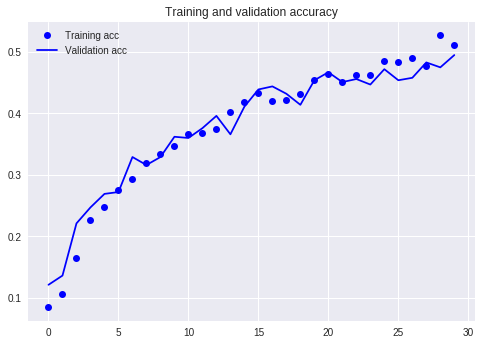

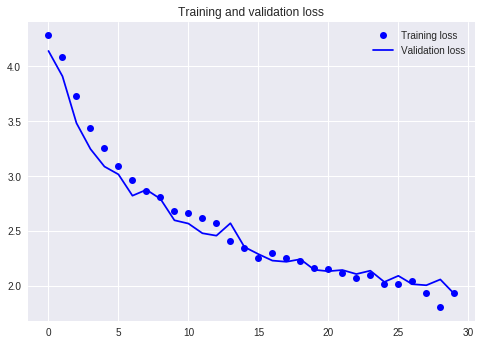

In [40]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [0]:
model1.evaluate(test_generator, y = ytestenc, batch_size=384, verbose=1)

In [42]:
print(test_dir)
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        classes=None,
        class_mode=None)


/content/plankton/test
Found 130400 images belonging to 1 classes.


In [0]:
from keras.models import load_model
saved_model = load_model('plankton_1.h5')

In [0]:
import numpy as np
res = model.predict_generator(test_generator)


In [44]:
len(test_generator.filenames)

130400

In [0]:
import pandas as pd
df = pd.DataFrame(data=res, columns=[*train_generator.class_indices])
df['image'] = [x.replace("test/","") for x in test_generator.filenames]
df['image']


In [71]:
df.to_csv("/content/plankton/result.csv", encoding='utf-8',index=False)
df.head()

,acantharia_protist,acantharia_protist_big_center,acantharia_protist_halo,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts,artifacts_edge,...,trochophore_larvae,tunicate_doliolid,tunicate_doliolid_nurse,tunicate_partial,tunicate_salp,tunicate_salp_chains,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified,image
0,0.028220,1.977395e-08,1.825410e-05,2.372684e-08,7.344640e-09,0.000034,0.000190,0.000084,0.122174,2.557359e-03,...,6.317570e-08,0.000021,0.000002,1.816994e-08,6.513609e-09,5.062655e-09,0.000431,0.000281,0.000585,1.jpg
1,0.000025,2.295016e-08,4.764014e-04,1.875574e-04,8.176722e-07,0.000263,0.000142,0.000265,0.000002,8.488574e-07,...,4.591848e-06,0.001316,0.001148,1.772603e-06,5.030629e-05,8.383949e-06,0.008346,0.000346,0.012560,10.jpg
2,0.017032,2.465684e-06,3.015024e-03,1.307744e-04,1.914554e-05,0.023317,0.019739,0.008481,0.017547,9.055361e-04,...,3.366441e-05,0.007432,0.001271,3.710407e-06,2.521064e-05,3.364211e-06,0.014288,0.008402,0.011961,100.jpg
3,0.000063,2.128904e-08,1.624104e-03,3.928225e-04,2.615836e-07,0.000141,0.000234,0.000827,0.000003,3.322414e-05,...,2.929890e-05,0.003914,0.006489,6.773369e-05,1.110332e-03,8.872343e-05,0.001414,0.000139,0.019378,1000.jpg
4,0.000025,1.177097e-09,2.473762e-07,1.305699e-04,7.218599e-09,0.000349,0.001096,0.004977,0.000002,1.088048e-05,...,6.341718e-08,0.000035,0.000592,1.186635e-05,9.566836e-06,3.341473e-05,0.002892,0.001429,0.002651,10000.jpg


In [72]:
result2 = pd.read_csv('/content/plankton/result.csv')
result2.columns

Index(['acantharia_protist', 'acantharia_protist_big_center',
       'acantharia_protist_halo', 'amphipods', 'appendicularian_fritillaridae',
       'appendicularian_s_shape', 'appendicularian_slight_curve',
       'appendicularian_straight', 'artifacts', 'artifacts_edge',
       ...
       'trochophore_larvae', 'tunicate_doliolid', 'tunicate_doliolid_nurse',
       'tunicate_partial', 'tunicate_salp', 'tunicate_salp_chains',
       'unknown_blobs_and_smudges', 'unknown_sticks', 'unknown_unclassified',
       'image'],
      dtype='object', length=122)

In [73]:
!kaggle competitions submit -c datasciencebowl -f /content/plankton/result.csv -m "first one"

Successfully submitted to National Data Science Bowl